In [1]:
local = True

# filter data for #votes >5
min_votes = 5
# Type of input data
data_type = "eeg_spec"  #"spec" # "eeg_raw" #
# number of subprocesses to use for data loading
import multiprocessing as cpu
num_workers = cpu.cpu_count() - 1
# how many samples per batch to load
batch_size = 64
# shuffle?
shuffle = True
# Is a test?
test = False

data_type, num_workers, batch_size, shuffle

('eeg_spec', 11, 64, True)

In [2]:
if not local:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
if not local:
    %cd /content/drive/MyDrive/Sun/ML Shock/Final project/

In [4]:
# Load (train or test) data from csv file
if local:
    path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/data/data/" #sample_data
    path_df = "C:\\Users\\Amy\\Desktop\\Green_Git\\eegClassification\\sample_data\\"
else:
    path = "./data/"
    path_df = "./data/"


In [5]:
import sys
if local:
    sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
else:
    sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [6]:
# Import libraries

import numpy as np
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import torch

from CustomDataLoader import CustomDataset
from torch.utils.data import DataLoader

In [7]:
def get_data_info(df, data_type):

    votes_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    # train is true id votes_cols are available
    train = all([col in df.columns for col in votes_cols])

    label_cols = (
        ["eeg_id", "label_id", "eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_id", "label_id", "spectrogram_label_offset_seconds"]
    )
    offset = (
        ["eeg_label_offset_seconds"]
        if "eeg" in data_type
        else ["spectrogram_label_offset_seconds"]
    )

    # if info_cols not in df add it and set to zero
    for col in offset:
        if col not in df.columns:
            df[col] = 0
    # if df does not contain "label_id" add a unique label_id
    if "label_id" not in df.columns:
        df["label_id"] = range(len(df))

    info = {}
    df_gr = df.groupby(label_cols)
    for name, group in df_gr:
        # first row of group
        info[name] = {"votes": group[votes_cols].values[0] if train else None}

    return info

In [8]:
df = pd.read_csv(path_df + f"train.csv")

df['total_votes'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)


In [9]:
# filter for min_votes
# df = df[df['total_votes'] >= min_votes]

In [10]:
p_id = df['patient_id'].unique()
np.random.shuffle(p_id)

# test train split 
train_p = p_id[:int(0.8*len(p_id))]
test_p = p_id[int(0.8*len(p_id)):]

In [11]:
len(df[df['patient_id'].isin(train_p)]), len(df[df['patient_id'].isin(test_p)]), len(df)

(84749, 22051, 106800)

In [12]:
# get the class label as the max vote
df['label'] = df[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].idxmax(axis=1)

(array([854.,   0., 694.,   0., 271.,   0.,  93.,   0.,  30.,   8.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

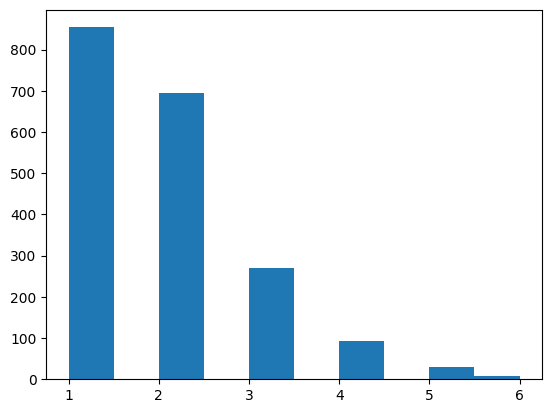

In [13]:
# group df by patient_id
df_grouped = df.groupby('patient_id')
# for each group count the number of unique labels
df_tmp = df_grouped['label'].nunique()

# histogram of number of unique labels per patient
plt.hist(df_tmp.values, bins=6)

In [14]:
def shuffle(info):
    info_shuffled = {}
    keys = [k for k in info.keys()]
    np.random.shuffle(keys)
    for key in keys:
        info_shuffled[key] = info[key]
        
    return info_shuffled

def sort_by_type(info):
    
    info_sorted = {}
    for idx in range(6):
        for key in info.keys():
            if np.argmax(info[key]['votes']) == idx:
                info_sorted[key] = info[key]
    
    return info_sorted


In [15]:
def egg_spec_augmentation(info):
    
    info_aug = info.copy()

    offset = [-1,1,-2,2,-3,3,-4,4]
    keys = [k for k in info_aug.keys()]
    N_item = len(keys)

    counts = [0]*6
    for k in info_aug.keys():
        idx = np.argmax(info_aug[k]['votes'])
        counts[idx] += 1

    for key in keys:

        # p = [x/np.sum(counts) for x in counts]
        # p_inv = [1/x for x in p]
        
        rates =[0.75, 0.2, 0.2, 0.2, 0.2, 0.2]
        #[(1-x)/x/np.sum(p_inv) for x in p]#[x/np.sum(p_inv) for x in p_inv]# [(1-x/np.sum(counts)) for x in counts]
        
        # generate random between 0 and 1
        r = np.random.rand()
        idx = np.argmax(info_aug[key]['votes'])

        if r < rates[idx]:
            # select a random offset
            off = np.random.choice(offset)
            new_key = (key[0], key[1], key[2] + off)
            # if new_key not in info add it
            if new_key not in info_aug.keys():
                info_aug[new_key] = info_aug[key]

            counts[idx] += 1

        # if len(info) >= N_item*(1+0.4):
        #     break

    return info_aug

In [16]:
info_train = get_data_info(df[df['patient_id'].isin(train_p)], data_type)

info_train = shuffle(info_train)

info_train_aug = egg_spec_augmentation(info_train)

In [17]:
counts = [0]*6
for k in info_train_aug.keys():
    idx = np.argmax(info_train_aug[k]['votes'])
    counts[idx] += 1

In [18]:
counts, [x/np.sum(counts) for x in counts]

([29270, 14846, 14210, 16244, 18134, 17933],
 [0.26455887270985295,
  0.13418657411173476,
  0.12843804513860643,
  0.14682249157153573,
  0.16390538427470014,
  0.16208863219356998])

In [19]:
counts = [0]*6
for k in info_train.keys():
    idx = np.argmax(info_train[k]['votes'])
    counts[idx] += 1

In [20]:
counts, [x/np.sum(counts) for x in counts]

([16742, 12444, 11889, 13587, 15088, 14999],
 [0.19754805366435002,
  0.14683359095682544,
  0.14028484111906925,
  0.16032047575782604,
  0.17803159919291084,
  0.17698143930901838])

In [21]:
for data_type in ["eeg_spec"]:#, "spec"]: 

    ###
    # info_train = get_data_info(df, data_type)
    ###
    # shuffles data
    info_train = get_data_info(df[df['patient_id'].isin(train_p)], data_type)
    info_train = shuffle(info_train)
    info_train_aug = egg_spec_augmentation(info_train)
    print(len(info_train), len(info_train_aug))

    info_test = get_data_info(df[df['patient_id'].isin(test_p)], data_type)
    ###


    data_dir = (
            f"train_eegs/"
            if "eeg" in data_type
            else f"train_spectrograms/"
        )
    data_dir = path + data_dir

    # for text, info in zip(["train"], [info_train]):
    for text, info in zip(["train", "test"], [info_train_aug, info_test]):
        
        # if local:
        #     # When running on a testing sample
        #     files = os.listdir(data_dir)
        #     df = df[
        #         df["eeg_id" if "eeg" in data_type else "spectrogram_id"].isin(
        #             [int(f.split(".")[0]) for f in files]
        #         )
        #     ]
        #     ##

        print(data_dir, data_type, len(info))

        dataset = CustomDataset(data_dir, data_type, info)
        data_loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )

        save_path = f"./data_prep_all_{data_type}/{text}/"
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # loop through data and save it as a numpy array
        count = 0
        for X, votes in tqdm(data_loader, desc=f"Saving {text} data"):
            # save the images
            np.save(save_path + f"images_{count}.npy", X.numpy())
            # save the votes
            np.save(save_path + f"votes_{count}.npy", votes.numpy())

            count += 1

            if test and count > 1:
                break

84749 111054
C:/Users/Amy/Desktop/Green_Git/eegClassification/data/data/train_eegs/ eeg_spec 111054


Saving train data: 100%|██████████| 1736/1736 [13:28<00:00,  2.15it/s]


C:/Users/Amy/Desktop/Green_Git/eegClassification/data/data/train_eegs/ eeg_spec 22051


Saving test data: 100%|██████████| 345/345 [02:30<00:00,  2.29it/s]


In [22]:
# load npy file
img = np.load(f"./data_prep_all_{data_type}/train/images_0.npy")
print(img.shape)

img = torch.tensor(img)

(64, 3, 140, 129)


In [23]:
# load npy file
class_votes = torch.tensor(np.load(f"./data_prep_all_{data_type}/train/votes_0.npy"))
print(class_votes.shape)

torch.Size([64, 6])


In [24]:
if data_type == "spec" or data_type == "eeg_spec":
    print(torch.mean(img.reshape(batch_size, 3, -1), axis = -1), torch.std(img.reshape(batch_size,3, -1), axis = -1))

tensor([[-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
        [-0.4850, -0.4560, -0.4060],
 

In [25]:
if data_type == "spec":
    sample_size = 8
    # show batch of images
    fig, ax = plt.subplots( sample_size//4,4, figsize = (5,5))
    for i in range(sample_size//4):
        for j in range(4):
            ax[i,j].imshow(img[i*4+j,0], interpolation='none')
            ax[i,j].axis("off")

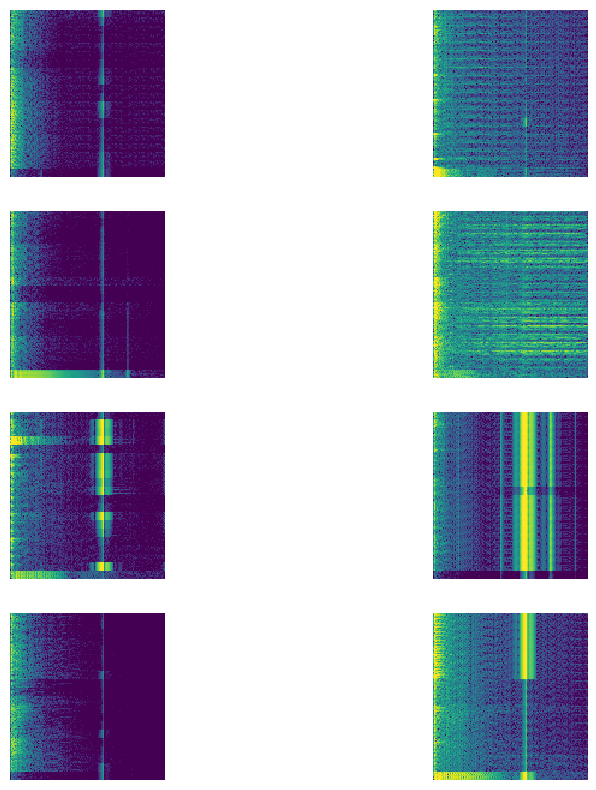

In [26]:
if data_type == "eeg_spec":
    sample_size = 8
    # show batch of images
    fig, ax = plt.subplots( 4,sample_size//4, figsize = (10,10))
    for j in range(sample_size//4):
        for i in range(4):
            ax[i,j].imshow(img[j*4+i,0], interpolation='none')
            ax[i,j].axis("off")

In [27]:
if data_type == "eeg_raw":
    sample_size = 8
    # show batch of images
    fig, ax = plt.subplots( sample_size//4,4, figsize = (5,5))
    for i in range(sample_size//4):
        for j in range(4):
            data = img[i*4+1].numpy()
            for k in range(20):
                ax[i,j].plot(data[k]+k*1000)


In [28]:
import torch.nn.functional as F
label_smoothing = 0.1
N_classes = 6
votes[0], F.softmax(votes.float(), dim=1)[0], F.softmax((votes * (1 - label_smoothing) + label_smoothing / N_classes).float(), dim=1)[0]

(tensor([ 0, 11,  0,  0,  0,  0]),
 tensor([1.6700e-05, 9.9992e-01, 1.6700e-05, 1.6700e-05, 1.6700e-05, 1.6700e-05]),
 tensor([5.0162e-05, 9.9975e-01, 5.0162e-05, 5.0162e-05, 5.0162e-05, 5.0162e-05]))

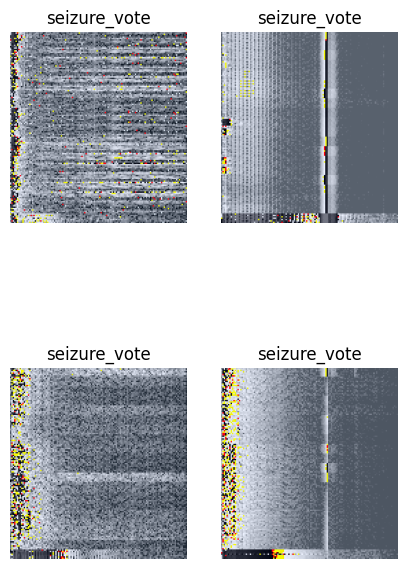

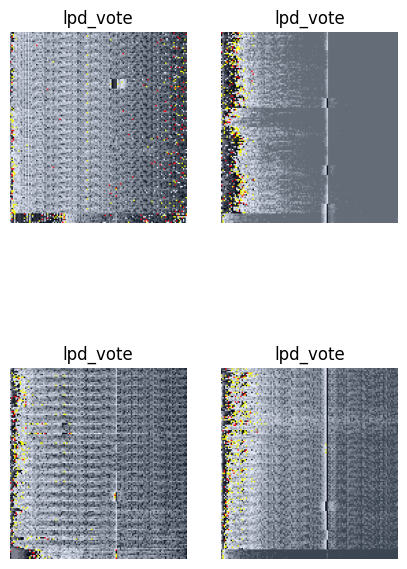

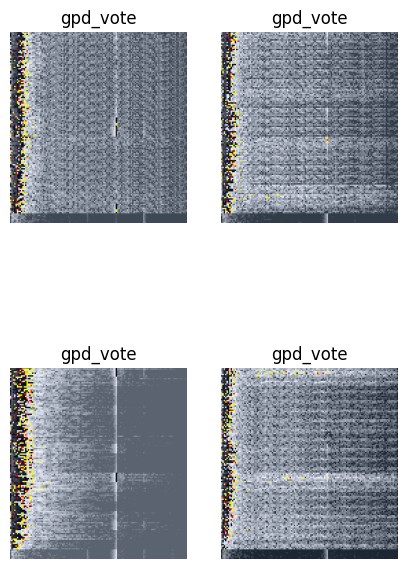

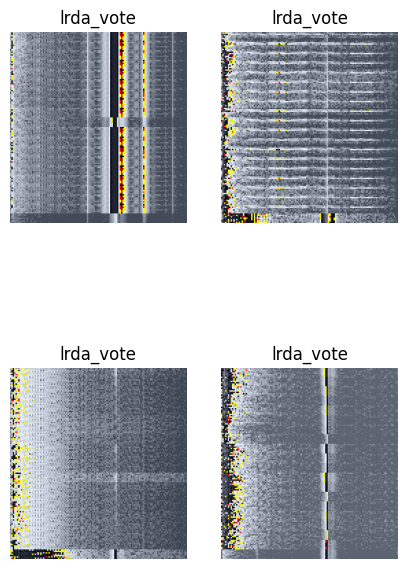

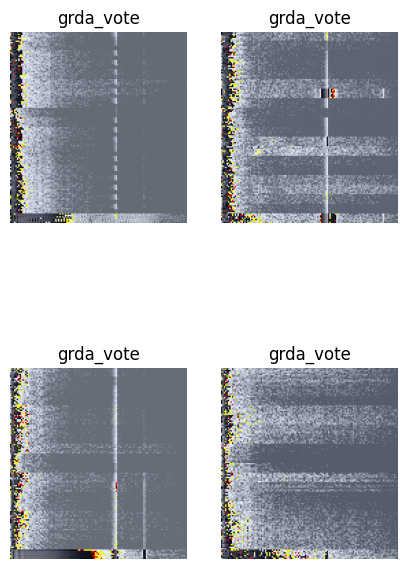

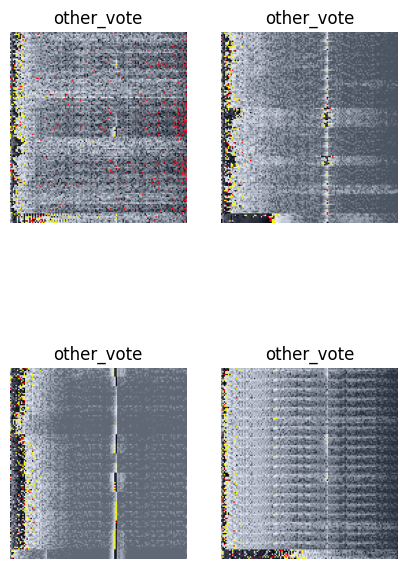

In [29]:
from torchvision.transforms import ToPILImage

# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)

# sort the labels in accending order
label = np.argmax(class_votes, axis=1)
label, indices = torch.sort(label)
data = img[indices, :]
class_votes = class_votes[indices, :]

# image show data
for i in range(N_classes):
    size = 4
    # indices of items in the class
    idxs = np.where(label == i)[0]
    # image show data
    fig, ax = plt.subplots(2, size//2, figsize = (5,8))
    # title
    ax[0,0].set_title(classes[i])
    for j in range(size//2):
        for i in range(2):
            if i*2+j > len(idxs)-1:
              ax[i,j].axis("off")
            else:
              idx = idxs[i*2+j]
              img = ToPILImage()(data[idx, :])
              ax[i,j].imshow(img)
              ax[i,j].set_title(classes[label[idx]])
              ax[i,j].axis("off")

    plt.show()
